In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gc
import numpy as np
import axelrod as axl
from time import time
from pprint import pprint
import matplotlib.pyplot as plt
from itertools import permutations
from collections import namedtuple, deque

np.set_printoptions(precision=3)

# the following imports are from network / axl_utils folder
import network
from axl_utils import NNplayer, State, set_match, set_play

In [3]:
C = axl.Action.C
D = axl.Action.D

# config game rules
GAME_LEN = 20 + 1
GAME = axl.Game(r=3, s=0, t=5, p=1)
Match = set_match(game=GAME, turns=GAME_LEN)
play = set_play(Match)

In [4]:
# the play function set up match between 2 players, print the result then return the match object
game = play(axl.Prober4(), axl.TitForTat())
game

[(3, 3), (3, 3), (5, 0), (0, 5), (5, 0), (1, 1), (1, 1), (0, 5), (3, 3), (5, 0), (0, 5), (5, 0), (0, 5), (3, 3), (5, 0), (0, 5), (5, 0), (1, 1), (0, 5), (5, 0)]
Player 1 score = 50
Player 2 score = 45


In [5]:
# this is how we define state, in 2d array    (3d for batch training)

s = State(GAME_LEN)
s.push(C, D)
print(s.values())

[[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1]
  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]]


### Section 1: DQN

In [6]:
dqn = network.DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 200),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(200, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 2),
                    ],
            network.ReplayMemory(2000), gamma=0.9, greedy=0.2)
p1 = NNplayer(dqn, State(GAME_LEN))
del dqn
gc.collect()

param = {"lr": 1e-4, 'batch': 64, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': None, "loss_fn":"mse"}

In [7]:
with p1:
    players = (p1, axl.TitForTat())
    game = Match(players)
    game.play()
    
# initial Q_value predictions:

[[1.228 1.947]]
[[0.492 1.687]]
[[0.089 1.496]]
[[-0.168  1.509]]
[[0.278 1.149]]
[[-0.21   1.737]]
[[0.133 1.396]]
[[-0.659  1.923]]
[[0.166 1.398]]
[[-0.096  1.643]]
[[0.129 0.607]]
[[-0.195  1.37 ]]
[[0.384 1.061]]
[[0.336 1.097]]
[[0.325 0.674]]
[[-0.088  0.997]]
[[-0.454  0.889]]
[[0.315 0.791]]
[[0.002 0.312]]
[[0.358 0.553]]
[[-0.105  0.102]]


In [8]:
# initial experience
# high greedy -> more random exploration

p1.set_greedy(0.8)
for i in range(60):
    players = (p1, axl.TitForTat())
    game = Match(players)
    game.play()
p1.set_greedy(0.2)

In [9]:
# theoritical Q values
# assuming the player cooperate til the last turn, then defect
true_Q = np.array([3.0+3.0/(1/9) * (1.0 - 1.0/(1.0+1/9)**(19-i)) + 2 for i in range(21)])
true_Q[20] = 0.0
[print(f'{i:.2f}') for i in true_Q];

28.35
27.95
27.50
27.00
26.44
25.82
25.14
24.37
23.53
22.59
21.54
20.38
19.09
17.65
16.06
14.29
12.32
10.13
7.70
5.00
0.00


In [10]:
# training loop

score_ls = []
errors = []
for _ in range(20):
    start = time()
    p1.train(30, param)
    
    # collect new experience with trained network
    [Match((p1, axl.TitForTat())).play() for _ in range(10)]
    
    print(f'loss: {p1.network.loss},            time: +{time()-start:.2f} sec')
    
    # calculating Q-value error for later use
    # a bit tedious here but I'm too lazy to fix
    values = []
    state = State(21)
    for i in range(21):
        value = p1.network(state.values())[0]
        values.append(value[0])
        state.push(C, C)
    error = true_Q - np.array(values)
    errors.append(error)


# left: running loss for cooperation
# right: running loss for defection

loss: [0.262 0.295],            time: +4.05 sec
loss: [0.219 0.171],            time: +5.62 sec
loss: [0.15  0.134],            time: +5.09 sec
loss: [0.108 0.111],            time: +5.56 sec
loss: [0.084 0.096],            time: +5.48 sec
loss: [0.073 0.077],            time: +6.26 sec
loss: [0.063 0.064],            time: +7.25 sec
loss: [0.051 0.057],            time: +5.73 sec
loss: [0.037 0.043],            time: +6.41 sec
loss: [0.032 0.033],            time: +7.03 sec
loss: [0.03  0.045],            time: +5.48 sec
loss: [0.032 0.043],            time: +6.29 sec
loss: [0.027 0.03 ],            time: +5.52 sec
loss: [0.024 0.035],            time: +6.41 sec
loss: [0.024 0.033],            time: +5.83 sec
loss: [0.02  0.024],            time: +5.73 sec
loss: [0.015 0.019],            time: +5.48 sec
loss: [0.019 0.021],            time: +5.27 sec
loss: [0.017 0.018],            time: +6.47 sec
loss: [0.018 0.022],            time: +6.00 sec


In [11]:
with p1:
    play(p1, axl.TitForTat())
# predicted Q-values:

[[26.526 25.857]]
[[26.122 25.397]]
[[25.857 25.162]]
[[25.342 24.635]]
[[24.831 23.972]]
[[24.272 23.521]]
[[23.622 22.965]]
[[22.961 22.212]]
[[22.137 21.426]]
[[21.322 20.591]]
[[20.313 19.658]]
[[19.172 18.609]]
[[18.009 17.308]]
[[16.647 15.91 ]]
[[15.2   14.524]]
[[13.518 12.866]]
[[11.752 11.214]]
[[9.693 9.069]]
[[7.456 5.789]]
[[2.98  5.027]]
[[-0.03   0.005]]
[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (5, 0)]
Player 1 score = 62
Player 2 score = 57


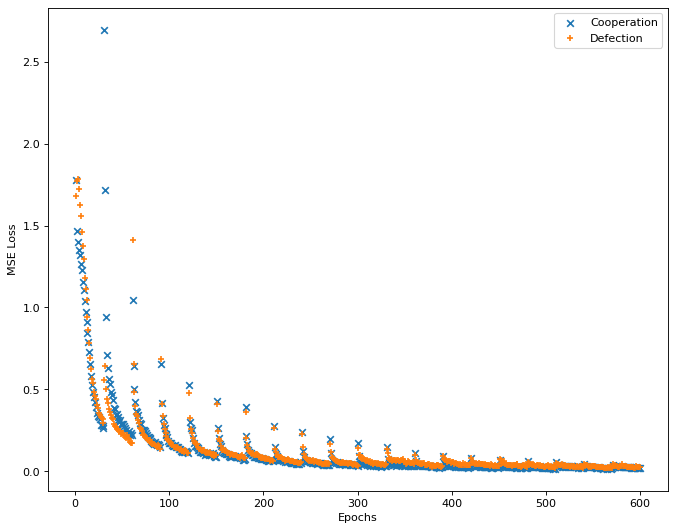

In [12]:
# training loss
# the beauty of double DQN
p1.plot()

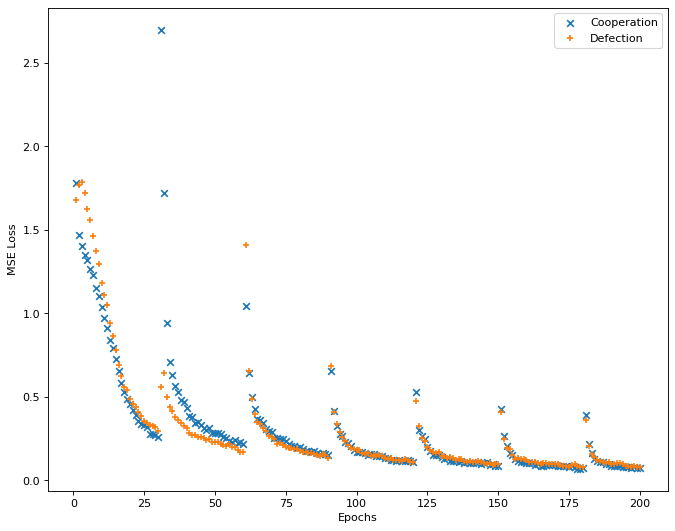

In [13]:
# zoom in first 200 epochs
p1.plot(min_ran=0, max_ran=200)

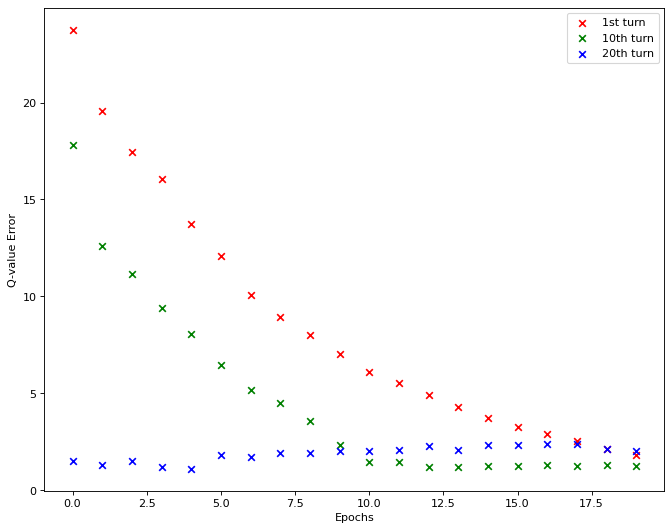

In [14]:
# visualizing the recursion nature of Bellman's equation,
# where the later states has to be learnt prior to learning preceding states

# plotting the error between our prediction against the theoritical Q-value
errors = np.array(errors)
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(range(len(errors)), errors[:,0], c='r', marker='x', label='1st turn')
plt.scatter(range(len(errors)), errors[:,9], c='g', marker='x', label='10th turn')
plt.scatter(range(len(errors)), errors[:,19], c='b', marker='x', label='20th turn')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Q-value Error')
plt.show()

### Section 2: DQN without fixed target (single DQN)

In [15]:
dqn2 = network.DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 100, bias=0.01),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 200),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(200, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 2),
                    ],
            network.ReplayMemory(2000), gamma=0.9, greedy=0.2)
p2 = NNplayer(dqn2, State(GAME_LEN))
del dqn2
gc.collect()

param = {"lr": 1e-4, 'batch': 64, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': None, "loss_fn":"mse"}

p2.set_greedy(0.8)
for i in range(60):
    players = (p2, axl.TitForTat())
    game = Match(players)
    game.play()
p2.set_greedy(0.2)

for _ in range(100):
    start = time()
    
    p2.train(1, param)  # my train function updates target net at the end via deepcopy, we can overwrite this by
    p2.network.target_net = p2.network.policy_net  # SHALLOW COPY policy net to target net
    
    [Match((p2, axl.TitForTat())).play() for _ in range(10)]
    print(f'loss: {p2.network.loss},            time: +{time()-start:.2f} sec')

loss: [1.822 1.955],            time: +0.42 sec
loss: [2.227 2.45 ],            time: +0.45 sec
loss: [2.397 2.151],            time: +0.48 sec
loss: [2.587 1.925],            time: +0.45 sec
loss: [2.433 1.762],            time: +0.46 sec
loss: [2.407 1.8  ],            time: +0.44 sec
loss: [2.161 1.684],            time: +0.55 sec
loss: [2.113 1.735],            time: +0.44 sec
loss: [1.939 1.806],            time: +0.45 sec
loss: [2.141 1.752],            time: +0.51 sec
loss: [1.761 1.724],            time: +0.51 sec
loss: [1.595 1.776],            time: +0.45 sec
loss: [1.815 1.991],            time: +0.44 sec
loss: [1.888 2.068],            time: +0.60 sec
loss: [1.823 2.159],            time: +0.62 sec
loss: [1.979 2.294],            time: +0.63 sec
loss: [2.111 2.499],            time: +0.53 sec
loss: [2.035 2.703],            time: +0.46 sec
loss: [2.087 3.019],            time: +0.46 sec
loss: [2.334 3.331],            time: +0.50 sec
loss: [2.503 3.729],            time: +0

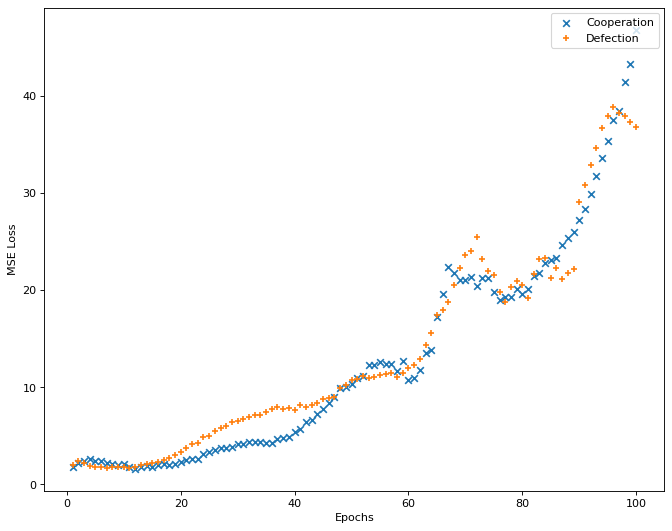

In [16]:
p2.plot()

In [17]:
# result:
with p2:
    play(p2, axl.TitForTat())
    
# incorrect Q-values -> bad policy

[[36.439 45.556]]
[[88.832 96.513]]
[[ 4.199 16.066]]
[[19.021 31.015]]
[[41.975 51.612]]
[[ 6.078 19.468]]
[[23.156 35.663]]
[[41.356 50.028]]
[[ 2.875 18.037]]
[[-4.144  7.739]]
[[18.209 29.628]]
[[ 3.233 14.346]]
[[34.343 41.353]]
[[ 5.834 17.592]]
[[29.162 38.03 ]]
[[11.025 20.182]]
[[17.19  25.586]]
[[10.738 18.161]]
[[14.136 19.097]]
[[1.385 7.389]]
[[ 8.354 10.607]]
[(5, 0), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)]
Player 1 score = 24
Player 2 score = 19


In [18]:
del p2

### Section 3: testing the off-policyness

In [19]:
from axl_utils.extract import extract

In [20]:
# collecting experience from axl.Random
memory = network.ReplayMemory(10000)
for _ in range(500):
    game = play(axl.Random(), axl.TitForTat(), show=False)
    extract(game, memory)

In [21]:
dqn3 = network.DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 100, bias=0.01),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 200),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(200, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 2),
                    ],
            memory, gamma=0.9, greedy=0.2)  # <- feeding the memory from axl.Random
p3 = NNplayer(dqn3, State(GAME_LEN))
del dqn3
gc.collect()

param = {"lr": 1e-4, 'batch': 64, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': None, "loss_fn":"mse"}

In [22]:
for _ in range(20):
    start = time()
    p3.train(5, param)
    print(f'loss: {p3.network.loss},            time: +{time()-start:.2f} sec')

loss: [0.29  0.385],            time: +5.66 sec
loss: [0.243 0.258],            time: +4.49 sec
loss: [0.219 0.217],            time: +4.35 sec
loss: [0.19  0.181],            time: +4.40 sec
loss: [0.174 0.19 ],            time: +4.22 sec
loss: [0.146 0.165],            time: +4.18 sec
loss: [0.157 0.157],            time: +5.00 sec
loss: [0.147 0.153],            time: +4.59 sec
loss: [0.135 0.145],            time: +4.53 sec
loss: [0.125 0.135],            time: +4.95 sec
loss: [0.128 0.124],            time: +5.95 sec
loss: [0.108 0.114],            time: +4.71 sec
loss: [0.105 0.112],            time: +4.61 sec
loss: [0.094 0.103],            time: +4.90 sec
loss: [0.091 0.105],            time: +5.10 sec
loss: [0.086 0.101],            time: +3.84 sec
loss: [0.093 0.092],            time: +5.40 sec
loss: [0.088 0.09 ],            time: +5.62 sec
loss: [0.077 0.09 ],            time: +9.68 sec
loss: [0.082 0.084],            time: +6.08 sec


In [23]:
with p3:
    play(p3, axl.TitForTat())
    
# learns exactly the same

[[26.516 25.926]]
[[26.102 25.462]]
[[25.427 24.838]]
[[24.809 24.171]]
[[24.102 23.439]]
[[23.453 22.814]]
[[22.871 22.308]]
[[22.274 21.584]]
[[21.553 20.939]]
[[20.851 20.085]]
[[19.812 19.317]]
[[18.911 18.562]]
[[17.79  17.037]]
[[16.075 15.566]]
[[14.466 14.168]]
[[12.871 12.381]]
[[11.14  10.755]]
[[9.548 9.245]]
[[7.126 5.747]]
[[2.986 4.941]]
[[0.304 0.345]]
[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (5, 0)]
Player 1 score = 62
Player 2 score = 57


In [24]:
del p3

### Section 4: did it learn Tit-For-Tat?

In [25]:
# might be an obvious question but let's see what happens if our DQN meets provocative defection

p1.network.greedy = 0.0
play(p1, axl.HardProber());  # hard prober defects forever if its opponent does not retaliate

[(0, 5), (0, 5), (3, 3), (3, 3), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (1, 1)]
Player 1 score = 7
Player 2 score = 92


In [26]:
play(axl.Cooperator(), axl.HardProber());  # our DQN is basically a naive cooperator

[(0, 5), (0, 5), (3, 3), (3, 3), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5)]
Player 1 score = 6
Player 2 score = 96


In [27]:
play(axl.TitForTat(), axl.HardProber());  # while TFT can generalize well to any opponent

[(0, 5), (1, 1), (5, 0), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]
Player 1 score = 57
Player 2 score = 57


In [28]:
# => continue exploration on Stage 2

In [29]:
# training TFT with 2 perceptrons

X = np.array([[1,1],[0,1],[1,0],[0,0]])  # possible states of last turn
y = np.array([[1],[1],[0],[0]])          # copy opponent's action

nn = network.NeuralNetwork([network.Linear_layer(2, 1)])
param = {"lr": 3e-2, 'batch': 2, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': None, "loss_fn":"mse"}

In [30]:
for i in range(40):
    nn.train(X, y, param)
    yhat = np.round(nn(X))
    acc = np.sum(yhat==y) / len(y)
    print(f"Epoch {i}, Accuracy = {acc}")

Average loss = 0.595053, elapsed time = 0.00.
Epoch 0, Accuracy = 0.5
Average loss = 0.533621, elapsed time = 0.00.
Epoch 1, Accuracy = 0.5
Average loss = 0.494105, elapsed time = 0.00.
Epoch 2, Accuracy = 0.5
Average loss = 0.429417, elapsed time = 0.00.
Epoch 3, Accuracy = 0.5
Average loss = 0.385835, elapsed time = 0.00.
Epoch 4, Accuracy = 0.75
Average loss = 0.349568, elapsed time = 0.00.
Epoch 5, Accuracy = 0.75
Average loss = 0.322200, elapsed time = 0.00.
Epoch 6, Accuracy = 0.5
Average loss = 0.277924, elapsed time = 0.00.
Epoch 7, Accuracy = 0.5
Average loss = 0.250987, elapsed time = 0.00.
Epoch 8, Accuracy = 0.5
Average loss = 0.231781, elapsed time = 0.00.
Epoch 9, Accuracy = 0.5
Average loss = 0.209439, elapsed time = 0.00.
Epoch 10, Accuracy = 0.75
Average loss = 0.181862, elapsed time = 0.00.
Epoch 11, Accuracy = 0.75
Average loss = 0.166591, elapsed time = 0.00.
Epoch 12, Accuracy = 0.75
Average loss = 0.150162, elapsed time = 0.00.
Epoch 13, Accuracy = 0.75
Average lo

In [31]:
# but this is more of a policy-gradient approach
# the regression nature of DQNs make it impossible to employ simple architecture